# Kills/Deaths

Let's check what happens when we only use kills and deaths.

First, our import statements

In [2]:
from dotenv import load_dotenv
import requests
import os
import json
import mysql.connector
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

Next, lets setup our DB connection using a .env file.

In [3]:
%load_ext dotenv
%dotenv

mydb = mysql.connector.connect(
    host = os.getenv('CRUC_DB_HOST'),
    user = os.getenv('CRUC_DB_USER'),
    passwd = os.getenv('CRUC_DB_PASSWD'),
    database = os.getenv('CRUC_DATABASE'),
    auth_plugin='mysql_native_password',
    pool_name='crucible_pool',
    pool_size=5
)
mycursor = mydb.cursor()

Now, let's grab the data and store it in a dataframe.

In [4]:
# get first 1000 rows from DB.
sql = f'SELECT * FROM `matches` LIMIT 1000;'
mycursor.execute(sql)
sqlreturn = mycursor.fetchall()
mydb.close()

# convert to DF 
df = pd.DataFrame(sqlreturn, columns = ['id', 'instanceId', 'team', 'kills', 'deaths', 'assists', 'members', 'duration', 'standing'])
df.head()

,id,instanceId,team,kills,deaths,assists,members,duration,standing
0,1,6494000521,0,38,28,9,3,883,0
1,2,6494000521,1,28,39,7,3,883,1
2,3,6494000682,0,10,33,2,3,468,1
3,4,6494000682,1,33,10,11,3,468,0
4,5,6494002122,0,36,28,12,3,881,0


So, most of the data is self explanetory.  Standing represents win/loss.  0 = win, 1 = loss.  We don't need the id, instanceId, team, or duration fields so let's drop those columns.  We will remove any rows where standing != 1 or 2 to avoid those outliers.  Also, let's remove games shorter than 2 minutes to remove outliers where teams left the match.

In [5]:
df = df[df.standing != 3]
df = df[df.duration > 120]
df = df.drop(['id', 'instanceId','assists','team','duration'], 1)
df = df.reset_index(drop=True)
df.head()

,kills,deaths,members,standing
0,38,28,3,0
1,28,39,3,1
2,10,33,3,1
3,33,10,3,0
4,36,28,3,0


Later on we may want to do averages for Kills, deaths, assists but for now we will look at totals, let's create a new df without the members field

In [6]:
matches_df = df.drop('members', 1)
matches_df.head()

,kills,deaths,standing
0,38,28,0
1,28,39,1
2,10,33,1
3,33,10,0
4,36,28,0


## Visualize the Data

Let's visualize kills and assists vs wins

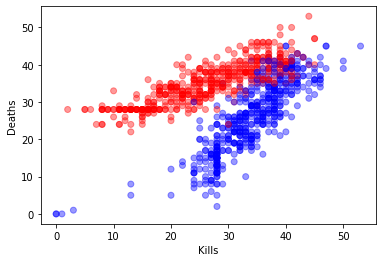

In [7]:
col = np.where(matches_df.standing==0,'b','r')
plt.scatter(matches_df.kills, matches_df.deaths,  color=col, alpha=0.4)
plt.xlabel("Kills")
plt.ylabel("Deaths")
plt.show()

Unsurpisingly, We can basically draw a line through our data at K/D = 1

Let's define our X and our y for the dataset

In [9]:
X = np.asarray(matches_df[['kills','deaths']])
y = np.asarray(matches_df['standing'])

## Create Model

Now, split into train and test sets

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (772, 2) (772,)
Test set: (193, 2) (193,)


Now, we need to create and train our model

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
model = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

Now, we can create two lists with predicted outcome and probability of outcome

In [12]:
yhat = model.predict(X_test)
yhat_prob = model.predict_proba(X_test)

Let's check the Jaccard index for accuracy

In [13]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat)

0.8210526315789474

Let's take a look at the advanced classificatio report

In [14]:
from sklearn.metrics import classification_report
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       109
           1       0.88      0.93      0.90        84

    accuracy                           0.91       193
   macro avg       0.91      0.91      0.91       193
weighted avg       0.91      0.91      0.91       193



So, it seems our model is 91% accurate which seems pretty good.  It is a little stronger identifying losses then wins.

Let's view the weights (thetas) for our model

In [16]:
cdf = pd.concat([pd.DataFrame(['kills','deaths']),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
print(cdf)

        0         0
0   kills -0.408277
1  deaths  0.408219


It seems kills and deaths are evenly weighted.
Finally, let's try some different values for C and see if they affect the outcome.

In [17]:
Cs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
Results = []
for c in Cs:
    model_temp = LogisticRegression(C=c, solver='liblinear').fit(X_train,y_train)
    yhat_temp = model_temp.predict(X_test)
    Results.append([c, jaccard_score(y_test, yhat_temp)])
results = pd.DataFrame(Results, columns = ['C Value', 'Jaccard Score'])
results

,C Value,Jaccard Score
0,0.001,0.821053
1,0.005,0.821053
2,0.010,0.821053
3,0.050,0.821053
4,0.100,0.821053
5,0.500,0.812500


Seems the c value does not have an impact on model accuracy.

# Conclusions

Results:
- The only real conclusion here is have a K/D over 1.  But that is kinda obvious so no surprise there

This model is able to predict with a high degree of accuracy.  We can now use this model to predict a players win percentage.

Let's take my current stats for this season and calculate my odds of winning (assuming my teammates also got my average of stats)
- Kills/game = 10.059524
- Deaths/game = 8.904762
- Assists/game = 3.702381
- Actual win percentage = 56%

In [18]:
mike_test = [[10.059524, 8.904762]]
mike_prob = model.predict_proba(mike_test)
print(mike_prob)

[[0.62174065 0.37825935]]


According to our model, a team of my clones performing at my average has a 65% chance of winning and 35% chance of lossing. <br>
Now, keep in mind this assumes a lot.  It assumes that both my teammates will perform the exact same as I do.  <br>
What we can say from this is that I, on average, am an asset to my team and contribute highly to my team